# xarray + dask for BOUT++ data analysis 

## Readable, general, and scalable data analysis in python

Thomas Nicholas

(thomas.nicholas@york.ac.uk)

# Outline

### Multidimensional data analysis

### What is xarray?

### xarray basic features

### Analysing large datasets with dask

### The xBOUT package

### Suggestions for community tools

# Multidimensional data analysis

All computational plasma physicists have some similar data analysis requirements:

- Relatively large datasets (up to 100's GBs)
- Multidimensional
- Warped-grid
- Fluid turbulence
- Visualise multiple dimensions easily
- Apply mathematical operations over many dimensions easily and clearly

For BOUT++ we want standard library with all this + open source

# What is xarray?

xarray is an open-source python library which provides Pandas-like labelling, visualisation & analysis functionality for N-dimensional data.

Developed by atmospheric physicists, who have similar data analysis needs to us

Already used extensively behind the scenes in OMFIT

### xarray basic features: 
- Labelled multidimensional data
- Clear syntax for operations
- Lazy loading into memory
- Plotting convenience

# xarray: Labelled multidimensional data

xarray wraps numpy arrays as "variables" and labels the dimensions.

There can be multiple "coordinates" for the same data.

Coordinates can be multidimensional
(e.g. for mapping Orthogonal toroidal coordinates -> field-aligned coordinates)

Multiple data variables are stored in same `Dataset`.

For example, imagine we had some output from an atmospheric fluid simulation...

<img src="images/dataset-diagram.png" style="width: 600px;">

In [ ]:
<xarray.Dataset>
Dimensions:        (t: 8, x: 8, y: 8)
Coordinates:
  * t              (t) int64 0 1 2 3 4 5 6 7 8
  * x              (x) int64 0 1 2 3 4 5 6 7 8
  * y              (y) int64 0 1 2 3 4 5 6 7 8
    latitude       (x, y) float32 numpy.array(8, 8)
    longitude      (x, y) float32 numpy.array(8, 8)
Data variables:
    temperature    (t, x, y) float32 numpy.array(8, 8, 8)
    precipitation  (t, x, y) float32 numpy.array(8, 8, 8)
Attributes:
    reference_time 123.0

Also carries around a dictionary of "attributes", which be used to store metadata as arbitary objects.

# xarray: Clear syntax for operations

We have some data $n(t,x,y,z)$, and we want to find the maximum over time of the spatially-averaged density at the separatrix. 

i.e. find $\text{max}(<n(t,x=\text{separatrix})>)$, where $<...>$ is an average over $y$ & $z$: 

Bare numpy:

In [ ]:
max_separatrix_density = np.max(np.mean(n[:, sep_x, ...], axis=(2,3)), axis=0)

xarray:

In [ ]:
max_separatrix_density = ds['n'].isel(x=sep_x).mean(dim=('y', 'z')).max(dim='t')

The xarray code is clearer, more generalisable, contains fewer "magic numbers", and the order of operations applied reads left-to-right.

# xarray: Lazy loading into memory

xarray uses the netCDF format in the backend.

Lazily loads data values - never waste RAM on unneeded values.

In [ ]:
import xarray as xr

# Open a 100GB file
ds = xr.open_dataset('BOUT_data.nc')

# Select a 1GB subset of the data
data = ds.isel(y=0)

# Data is only loaded into memory here, when we actually need it
result = some_maths(data)

# xarray: Plotting convenience

xarray provides plotting functions which wrap matplotlib:

In [6]:
# Skip this in presentation because it just loads data
%matplotlib notebook

from xbout import open_boutdataset

ds = open_boutdataset('/home/tnichol/runs/2d/core_phi_visc_scan/visc_3.7e0_vortloss_1.0e0/BOUT.dmp.*.nc')
ds['x'].attrs['units'] = 'rho_s'
ds['z'].attrs['units'] = 'rho_s'

ds['phi'].attrs['units'] = 'V'
ds['phi'].name = 'Potential'
ds['T'].name = 'Electron temperature'

Read in:
<xbout.BoutDataset>
Contains:
<xarray.Dataset>
Dimensions:         (t: 1001, x: 480, y: 1, z: 256)
Dimensions without coordinates: t, x, y, z
Data variables:
    t_array         (t) float64 0.0 80.0 160.0 ... 7.984e+04 7.992e+04 8e+04
    dx              (x, y) float64 dask.array<shape=(480, 1), chunksize=(10, 1)>
    dy              (x, y) float64 dask.array<shape=(480, 1), chunksize=(10, 1)>
    g11             (x, y) float64 dask.array<shape=(480, 1), chunksize=(10, 1)>
    g22             (x, y) float64 dask.array<shape=(480, 1), chunksize=(10, 1)>
    g33             (x, y) float64 dask.array<shape=(480, 1), chunksize=(10, 1)>
    g12             (x, y) float64 dask.array<shape=(480, 1), chunksize=(10, 1)>
    g13             (x, y) float64 dask.array<shape=(480, 1), chunksize=(10, 1)>
    g23             (x, y) float64 dask.array<shape=(480, 1), chunksize=(10, 1)>
    g_11            (x, y) float64 dask.array<shape=(480, 1), chunksize=(10, 1)>
    g_22            (x, y) 

<IPython.core.display.Javascript object>


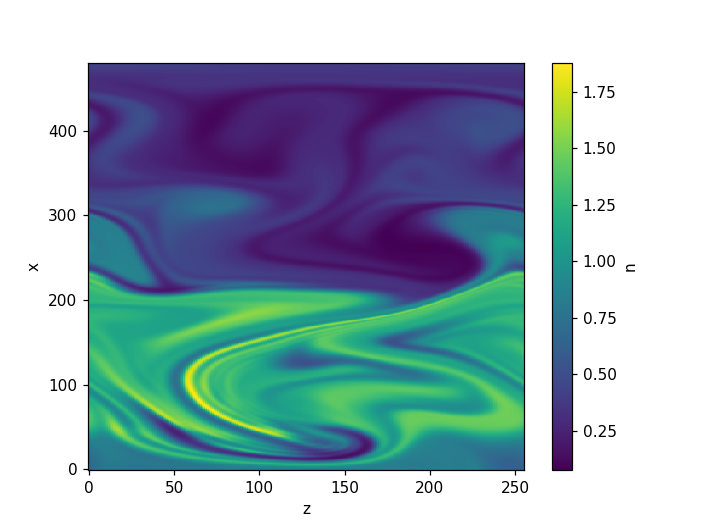

In [10]:
ds['n'].isel(t=100, y=0).plot()

Notice the axes and title are automatically created (this info must be stored in the dataset obviously)

These plotting functions automatically use an appropriate type of plot for the dimension of the data (1D, 2D etc.)

In [ ]:
profile = ds['T'].mean(dim=('t', 'y', 'z'))

# Hide the creation of the new figure?
fig, ax = plt.subplots()
profile.plot.line(ax=ax)

#plot_separatrix(data, sep_position, ax=ax)

In [ ]:
# <img src="T_profile.png" alt="Drawing" style="width: 600px;">

I've used this to write functions which plot 2D animated gifs which can animate over any dimension.

In [ ]:


data.bout.animate2D(animate_over='t', x='x', y='z')

In [ ]:
# ![tempgif](T_over_time.gif "segment")

# xarray + dask:

- Memory chunking
- Parallel analysis

If you also install [dask](http://docs.dask.org/en/latest/install.html) (literally that's it, no other compiling or anything required), xarray will provide the option to load data into memory in chunks.

### xarray + dask: Memory chunking

In [ ]:
ds = xr.open_dataset('example-data.nc', chunks={'time': 10})

print(ds)

In [ ]:
<xarray.Dataset>
Dimensions:      (latitude: 180, longitude: 360, time: 365)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01 2015-01-02 2015-01-03 ...
  * longitude    (longitude) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * latitude     (latitude) float64 89.5 88.5 87.5 86.5 85.5 84.5 83.5 82.5 ...
Data variables:
    temperature  (time, latitude, longitude) float64 dask.array<shape=(365, 180, 360), chunksize=(10, 180, 360)>

Now if you apply any xarray or any "embarrassingly parallel" numpy function to this dataset then it will compute the result only on one chunk at a time, and combine the results at the end.

Useful when you have "medium data": larger than your RAM but smaller than your hard drive (so not "big data"). 

### xarray + dask: Parallel analysis

dask can also automatically parallelize the opertation of any xarray function, and most numpy and scipy functions, using the ``apply_ufunc`` helper function: 

In [ ]:
xr.apply_ufunc(some_numpy_analysis_fn, ds, dask='parallelized', output=[float])

Chunking and parallelization through dask integration should allow you to easily scale up whatever analysis you were doing with numpy to work on datasets that are 100's of GBs in size.

# The xBOUT package

[xBOUT](https://github.com/TomNicholas/xBOUT) aims to replace the pylib/boutdata tools which are currently in the BOUT++ repository. 

Provides a simple interface for loading BOUT++ data as an xarray dataset efficiently from parallel simulation runs.

Stores the numerical data from the dump files, but also uses Ben's `BoutOptionsFile()` classes to store all simulation input in the attributes dictionary:

In [ ]:
import xarray as xr
from xbout import open_boutdataset

ds = open_boutdataset('BOUT.dmp.*.nc', inputfilepath='BOUT.inp')

Data is stored lazily, and read in parallel using dask automatically.

Faster than the current `boutdata.collect()` function (PROVE THIS)

Core functionality implemented upstream in xarray ([Pull Request](https://github.com/pydata/xarray/pull/2553) waiting to be merged)

Written using test-driven-development.

### Accessors

Uses another feature of xarray - accessors - to provide BOUT-specific functionality as methods:

In [ ]:
from xbout import open_boutdataset

ds = open_boutdataset('BOUT.dmp.*.nc')

ds.bout.to_restarts(savepath='.', nxpe=4, nype=6)

In [ ]:
ds['n'].bout.animate2D(animate_over='t', x='x', y='z')

Package includes methods to perform common types of plasma turbulence data analysis (all parallelized using dask):

(e.g. pdfs, ExB velocity, conditional averaging)

In [ ]:
ds['n'].bout.growth_rate()

### Subclassing for specific users

Tools for general use in `xBOUT`, but `boutdataset` accessor allows subclassing for specific BOUT++ modules:

In [ ]:
from xbout.boutdataset import open_boutdataset, BoutAccessor

@register_dataset_accessor('storm')
class StormAccessor(BoutAccessor):
    """
    Class specifically for holding data from a simulation using the STORM module for BOUT++.
    """
    def __init__(self, ds):
        super().__init__(ds)

    def plot_special_storm_plot()
        print("STORM-specific functionality!")

In [ ]:
ds = open_boutdataset('BOUT.dmp.*.nc')
ds.storm.plot_special_storm_plot()

# Suggestions for BOUT++ community tools

### Multidimensional coordinates

Coordinates can be multidimensional

Store mapping between (r,z,phi) -> Boozer coordinates as a 3D coord Boozer

### Common plotting functions

In [ ]:
ds['n'].bout.plot_poloidal()

### More analysis functions

Growth rates, power spectra...

### Staggered grids using xgcm

Interesting work going on in the [xgcm](https://github.com/xgcm/xgcm) package 

xgcm (Xarray for Global Circulation Models) aims to provide objects which encode complex grids for use with xarray.

Can encode and perform operations on staggered grids:

<img src="images/grid2d_hv.svg">

### Complex topologies using xgcm

xgcm can also encode complex topologies by storing connections between different cartesian grids:

<img src="images/cubed_sphere.jpeg" alt="Drawing" style="width: 400px;">

# Conclusion

Everyone who analyses multidimensional simulation data in python has similar needs

Atmospheric physicists have already solved this problem for us: [xarray + dask](http://xarray.pydata.org/en/stable/index.html)

Extendable API ideal for the varied BOUT++ community

Basic functionality already exists ([xBOUT](https://github.com/TomNicholas/xBOUT))

Potential for powerful common features 

# Resources

Blog post introducing xarray:
http://stephanhoyer.com/2015/06/11/xray-dask-out-of-core-labeled-arrays/


xarray GitHub:
https://github.com/pydata/xarray/


xarray documentation:
http://xarray.pydata.org/en/stable/


xarray documentation on dask integration:
http://xarray.pydata.org/en/stable/dask.html


Other useful blogs/tutorials:
http://meteo.unican.es/work/xarray_seminar/xArray_seminar.html
https://rabernat.github.io/research_computing/xarray.html


Useful page from the dask documentation explaining the general idea:
http://docs.dask.org/en/latest/delayed.html

# Bonus: How does dask work?

<img src="images/collections-schedulers.png">

Dask works by:
    
- Labelling the various operations you want to perform, using either dask objects like dask.arrays or encoding general functions using dask.delayed

- Instead of evaluating these operations, it organises them into a Task Graph for later evaluation

- Evaluates them using one of a set of Schedulers, which can perform in parallel.

In [8]:
def inc(x):
    return x + 1

def add(x, y):
    return x + y

In [9]:
import dask

x = dask.delayed(inc)(1)
y = dask.delayed(inc)(2)
z = dask.delayed(add)(x, y)
z.compute()

5

In [ ]:
z.vizualize()

<img src="images/inc-add.svg">